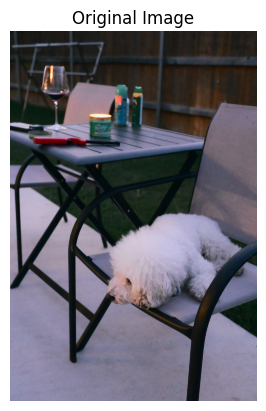

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# Load an RGB image
INPUT_IMAGE = 'input/DSC_6450.JPG'
img = cv2.imread(INPUT_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()


In [2]:
# Convert to grayscale and threshold
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


from skimage.morphology import local_maxima

# Compute distance transform
distance = ndi.distance_transform_edt(binary)

# Use local_maxima instead of deprecated peak_local_max
local_maxi = local_maxima(distance)

# Label connected regions
markers = ndi.label(local_maxi)[0]

# Apply watershed
labels = watershed(-distance, markers, mask=binary)


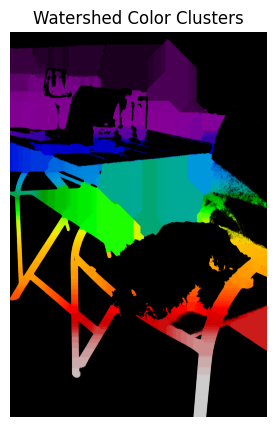

In [3]:
from matplotlib import cm

# Display watershed results
plt.figure(figsize=(10, 5))
plt.imshow(labels, cmap=cm.nipy_spectral)
plt.title("Watershed Color Clusters")
plt.axis('off')
plt.show()


In [4]:
labels 

array([[ 1,  1,  1, ..., 30, 30, 30],
       [ 1,  1,  1, ..., 30, 30, 30],
       [ 1,  1,  1, ..., 30, 30, 30],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], shape=(6048, 4032), dtype=int32)

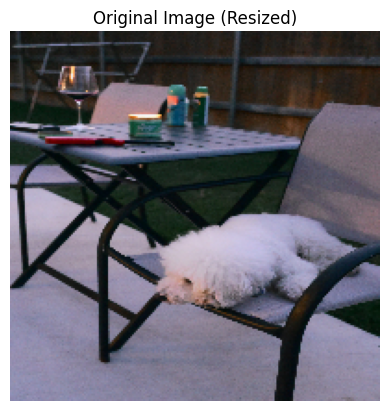

In [5]:
# Step 1: Load and Prepare Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image and resize for speed
INPUT_IMAGE = 'input/DSC_6450.JPG'
img = cv2.imread(INPUT_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_small = cv2.resize(img, (200, 200))  # Resize to speed up clustering

plt.imshow(img_small)
plt.title("Original Image (Resized)")
plt.axis('off')
plt.show()

In [6]:
# Step 2: Cluster Colors with K-Means
from sklearn.cluster import KMeans

# Flatten image to (num_pixels, 3)
pixels = img_small.reshape((-1, 3))

# Apply K-means clustering
n_colors = 5
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
labels = kmeans.labels_.reshape(img_small.shape[:2])

In [7]:
# Step 3: Watershed Refinement (Edge-aware)
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.morphology import local_maxima

# Compute edges
edges = sobel(cv2.cvtColor(img_small, cv2.COLOR_RGB2GRAY))

# For each KMeans cluster, apply Watershed refinement
refined_labels = np.zeros_like(labels)

for i in range(n_colors):
    mask = (labels == i).astype(np.uint8)

    # Distance transform & local maxima
    distance = ndi.distance_transform_edt(mask)
    local_maxi = local_maxima(distance)
    markers = ndi.label(local_maxi)[0]

    # Apply watershed inside the mask
    refined = watershed(-distance, markers, mask=mask)
    refined_labels[refined > 0] = i + 1  # Ensure non-zero labels


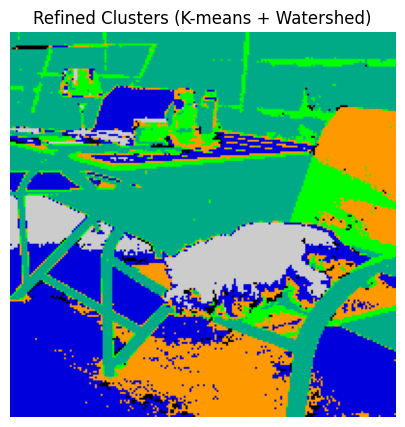

In [8]:
# Step 4: Visualize the Refined Clusters
from matplotlib import cm

plt.figure(figsize=(10, 5))
plt.imshow(refined_labels, cmap=cm.nipy_spectral)
plt.title("Refined Clusters (K-means + Watershed)")
plt.axis('off')
plt.show()

In [ ]:
refined_labels

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 4],
       [1, 1, 1, ..., 1, 1, 1]], shape=(200, 200), dtype=int32)

: 

In [ ]:
# Updated Notebook: Spatially Connected Perceptual Color Clustering
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from skimage.color import rgb2lab
from skimage.measure import label

# Load and resize image
img = cv2.imread(INPUT_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_small = cv2.resize(img, (300, 300))  # Resize for speed

# Convert to perceptual color space (Lab)
lab_img = rgb2lab(img_small)
lab_flat = lab_img.reshape(-1, 3)

# Use DBSCAN to automatically detect color clusters
# eps: perceptual distance, min_samples: minimum cluster size
db = DBSCAN(eps=6.5, min_samples=50).fit(lab_flat)
color_labels = db.labels_.reshape(img_small.shape[:2])

# Map each color label to connected spatial regions
connected_labels = np.zeros_like(color_labels)

label_counter = 1
for unique_label in np.unique(color_labels):
    if unique_label == -1:
        continue  # Skip noise

    mask = (color_labels == unique_label).astype(np.uint8)
    spatial_clusters = label(mask, connectivity=1)

    # Offset each label to keep unique global IDs
    spatial_clusters[spatial_clusters > 0] += label_counter
    connected_labels += spatial_clusters
    label_counter = connected_labels.max() + 1


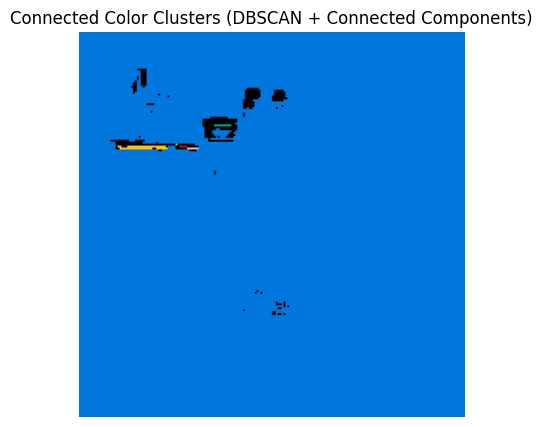

In [ ]:
from matplotlib import cm

plt.figure(figsize=(10, 5))
plt.imshow(connected_labels, cmap=cm.nipy_spectral)
plt.title("Connected Color Clusters (DBSCAN + Connected Components)")
plt.axis('off')
plt.show()